In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from zipfile import ZipFile
zf = ZipFile("/content/gdrive/MyDrive/archive.zip")
zf.extractall('/content')
zf.close()

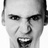

In [ ]:
#Accecsing one image
from PIL import Image
img = Image.open('/content/images/train/angry/10154.jpg')
img

In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.3,
     shear_range = 0.3,
     rotation_range=30,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/images/train",
                                               target_size=(48,48),
                                               batch_size=32,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 28821 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes={0:'Angry',
         1:'Disgust',
         2:'Fear',
         3:'Happy',
         4:'Neutral',
         5:'Sad',
         6:'Surprise'}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/images/train",
                                           target_size=(48,48),
                                           batch_size=32,
                                           class_mode='categorical',
                                  )

Found 28821 images belonging to 7 classes.


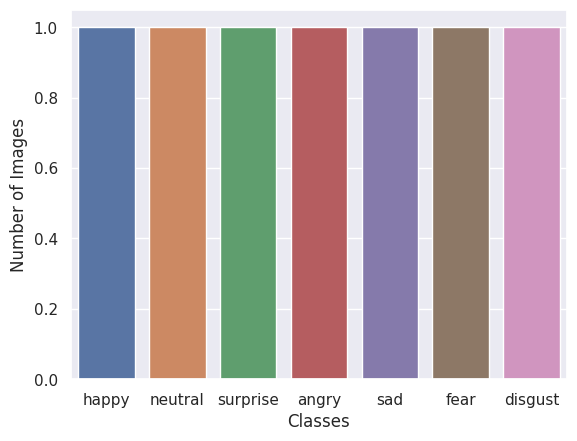

In [ ]:
path = '/content/images/train'

class_counts = {}

for subdir in os.listdir(path):
    subdir_path = os.path.join(path, subdir)
    class_counts[subdir] = len(os.listdir(subdir_path))

sns.countplot(x=list(class_counts.keys()), data=None)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

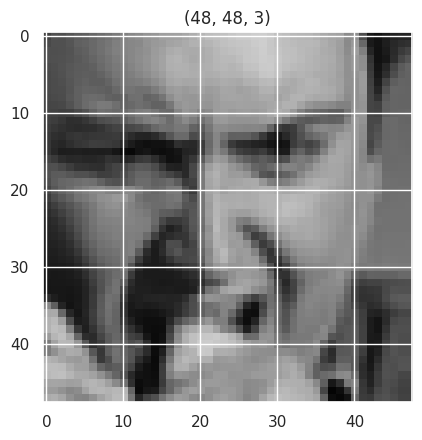

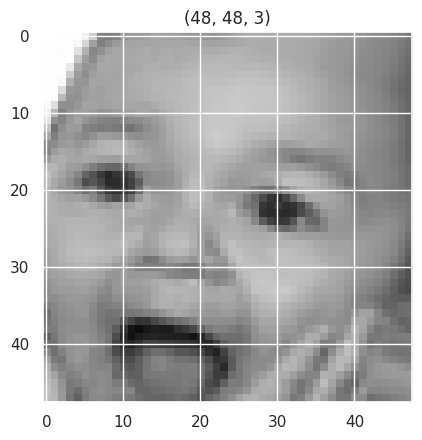

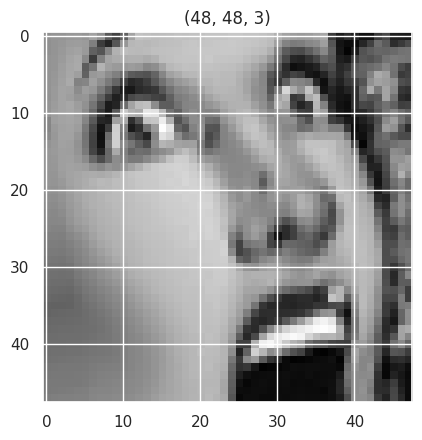

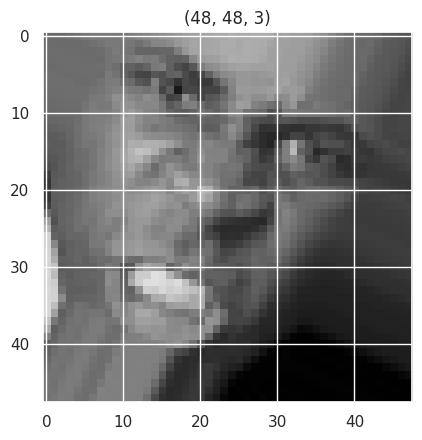

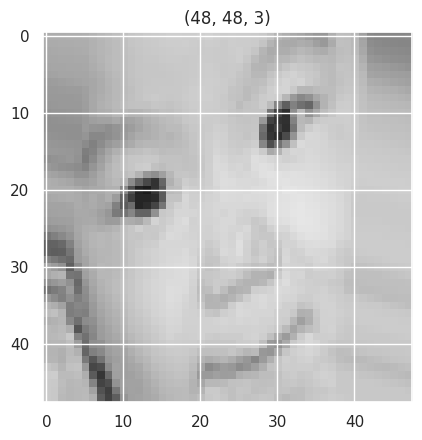

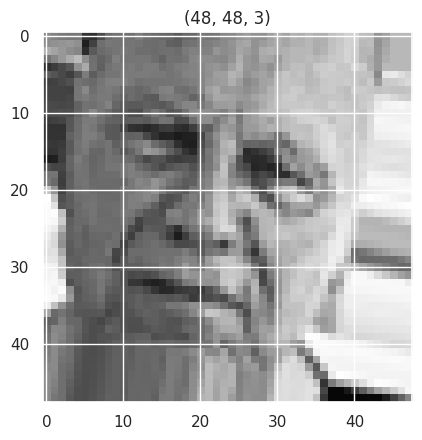

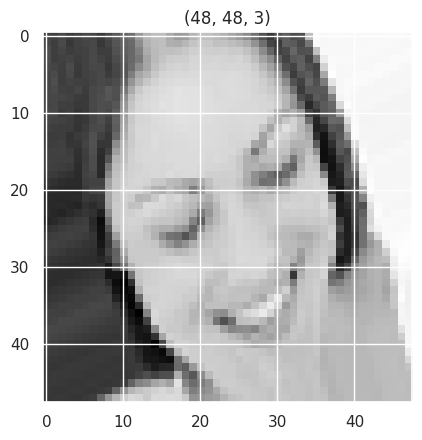

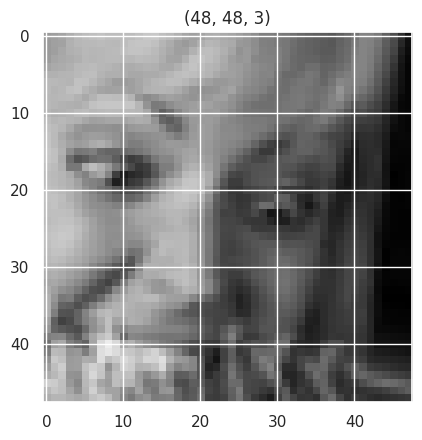

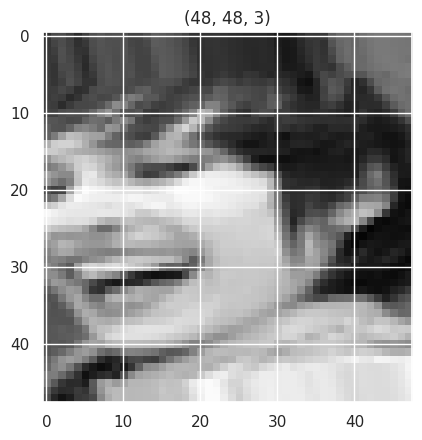

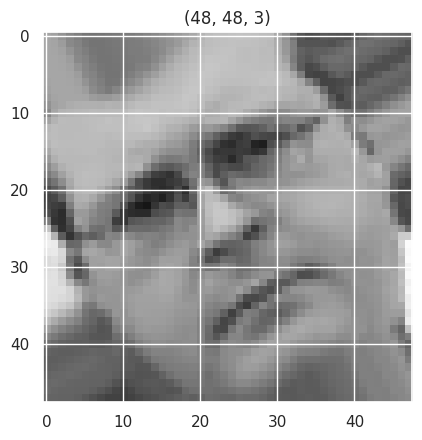

In [ ]:
t_img , label = train_data.next()

def plotImages(img_arr, label):

  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()

    count += 1
    if count == 10:
      break

plotImages(t_img, label)

In [ ]:
base_model = MobileNet( weights = 'imagenet', input_shape = (48,48,1), include_top = False )

for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)
x = Dense(units=7 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

In [ ]:
checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [ ]:
hist = model.fit(train_data, epochs = 31, validation_data = val_data, callbacks = callbacks_list)

Epoch 1/31
451/451 [==============================] - ETA: 0s - loss: 1.5594 - accuracy: 0.3689
Epoch 1: val_accuracy improved from -inf to 0.37733, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


451/451 [==============================] - 452s 965ms/step - loss: 1.5594 - accuracy: 0.3689 - val_loss: 1.5935 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 2/31
451/451 [==============================] - ETA: 0s - loss: 1.3380 - accuracy: 0.4855
Epoch 2: val_accuracy improved from 0.37733 to 0.42511, saving model to best_model.h5
451/451 [==============================] - 431s 955ms/step - loss: 1.3380 - accuracy: 0.4855 - val_loss: 1.5536 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 3/31
451/451 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.5151
Epoch 3: val_accuracy did not improve from 0.42511
451/451 [==============================] - 431s 957ms/step - loss: 1.2644 - accuracy: 0.5151 - val_loss: 2.0397 - val_accuracy: 0.2705 - lr: 0.0010
Epoch 4/31
451/451 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.5355
Epoch 4: val_accuracy did not improve from 0.42511
451/451 [==============================] - 433s 960ms/step - loss: 1.2181 - accu

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
def predict_image(model_path, image_path):
    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Make predictions
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)

    return predicted_label

model_path = "/content/best_model (4).h5"
image_path = "/content/images/train/happy/10035.jpg"

predicted = predict_image(model_path, image_path)
print("Predicted Label:", classes[predicted])

1/1 [==============================] - 7s 7s/step
Predicted Label: Happy


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
def predict_image(model_path, image_path):
    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Make predictions
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)

    return predicted_label

model_path = "/content/best_model (4).h5"
image_path = "/content/WhatsApp Image 2023-10-23 at 5.34.27 PM (1).jpeg"

predicted = predict_image(model_path, image_path)
print("Predicted Label:", classes[predicted])

1/1 [==============================] - 0s 379ms/step
Predicted Label: Sad


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
import tensorflow as tf

face_classifier=cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
classes={0:'Angry',
         1:'Disgust',
         2:'Fear',
         3:'Happy',
         4:'Neutral',
         5:'Sad',
         6:'Surprise'}

emotion_model = load_model("/content/best_model (4).h5")

cap=cv2.VideoCapture(0)

while True:
    ret,frame=cap.read()
    print(frame)
    labels=[]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        #cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(224,0,0),2)
        roi_gray=gray[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(224,224),interpolation=cv2.INTER_AREA)

         #Get image ready for prediction
        roi=roi_gray.astype('float')/255.0  #Scale
        roi=img_to_array(roi)
        #roi=np.expand_dims(roi,axis=0)  #Expand dims to get it ready for prediction (1, 48, 48, 1)
        roi=np.expand_dims(roi,axis=-1)

        preds=emotion_model.predict(roi)[0]  #Yields one hot encoded result for 7 classes
        label=class_labels[preds.argmax()]  #Find the label
        label_position=(x,y)
        cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),3)
    cv2.imshow('Emotion Detector', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  #Press q to exit
        break
cap.release()
cv2.destroyAllWindows()